In [1]:
    import msprime
    from IPython.display import SVG
    # Doing this to make the notebook outputs deterministic. 
    # DO NOT DO THIS IN YOUR CODE
    msprime.core.set_seed_rng_seed(42)

(sec_ancestry)=

# Ancestry

Msprime simulates the ancestry of sampled genomes under a number of 
different backwards-in-time population genetic 
{ref}`models <sec_ancestry_models>`. The simulated ancestry is 
represented as a [succinct tree sequence](https://tskit.dev) using 
the [tskit](https://tskit.dev/tskit) library, which provides an
extensive suite of operations for analysing genealogical trees
and DNA sequence data. See the {ref}`tutorials:sec_tskit_getting_started`
tutorial for more information on how to process data using tskit.

Here we run a simple simulation and show a summary of the resulting
tree sequence:

In [2]:
ts = msprime.sim_ancestry(2)
ts

The {func}`.sim_ancestry` function has many parameters to specify
the details of the simulations. The {func}`API documentation <.sim_ancestry>`
contains a precise description of the parameter; the sections 
in this page provide some explanation and examples of how to use these 
parameters.

:::{note}
It's important to note that {func}`.sim_ancestry` only simulates
the ancestral trees for samples: if we want actual sequence data 
then we need to additionally simulate mutations on these trees.
See the {ref}`sec_mutations` section for more information on how to do
this.
:::

---

## Quick reference

{func}`.sim_ancestry`
: Simulate ancestral tree sequence topology

**Models**

{class}`.StandardCoalescent`
: Coalescent with recombination ("hudson")

{class}`.SmcApproxCoalescent`             
: Sequentially Markov Coalescent ("smc")    

{class}`.SmcPrimeApproxCoalescent`        
: SMC'("smc_prime")                         

{class}`.DiscreteTimeWrightFisher`        
: Generation-by-generation Wright-Fisher    

{class}`.BetaCoalescent`
: Beta coalescent multiple-merger           

{class}`.DiracCoalescent`                 
: Dirac coalescent multiple-merger          

{class}`.SweepGenicSelection`             
: Selective sweep at a linked locus         

---

(sec_ancestry_samples)=
## Specifying samples

In [3]:
    msprime.core.set_seed_rng_seed(42)

The `samples` argument to {func}`.sim_ancestry` defines the number
of sample individuals we simulate the history of. There are three different
forms; the `samples` argument can be:

- an **integer**, interpreted as the number of samples to draw in a single
  population model;
- a **dictionary** mapping population references (either integer IDs or
  names) to the number of samples for that population;
- a list of {class}`.SampleSet` objects, which provide more flexibility
  in how groups of similar samples are drawn from populations.


In the simplest case provide a single integer which defines the number
of samples:

In [4]:
ts = msprime.sim_ancestry(2)
ts

:::{warning}
It is important to note that the number of samples
refers to the number of *individuals* not the number of *nodes*
(monoploid genomes). See the {ref}`sec_ancestry_ploidy`
section for details.
:::

### Populations

```{eval-rst}
.. todo:: Some text here that refers to the demography section.
```

The next example illustrates one usage of the dictionary form of the `samples`
argument. We first create a {class}`.Demography` object representing
a 10 deme linear stepping stone model. Then, we run the simulation
with 1 diploid sample each drawn from the first and last demes in this
linear habitat.

In [5]:
N = 10
demography = msprime.Demography.stepping_stone_model(
    [100] * N,
    migration_rate=0.1,
    boundaries=True)
ts = msprime.sim_ancestry({0: 1, N - 1: 1}, demography=demography)
ts

The keys in the dictionary can also be the string names of the
population, which is useful when we are simulating from empirically
estimated models. For example, here create a {class}`.Demography` object
based on a species tree, and then draw samples using the species names.

In [6]:
demography = msprime.Demography.from_species_tree(
    "(((human:5.6,chimpanzee:5.6):3.0,gorilla:8.6):9.4,orangutan:18.0)",
    branch_length_units="myr",
    initial_size=10**4,
    generation_time=20)
ts = msprime.sim_ancestry({"gorilla": 2, "human": 4}, demography=demography)
ts

(sec_ancestry_samples_sampling_time)=

### Sampling time

By default the samples that we draw from a {class}`.Population` are the
population's `sampling_time`. This is usually zero, representing the
present, but in some demographic models representing (for example)
with populations representing archaic individuals the default sampling
time might be older. We can manually control the time at which samples
are drawn using list of {class}`.SampleSet` objects form for the
samples argument.

id	flags	population	individual	time	metadata
0	1	0	0	0.00000000000000	
1	1	0	0	0.00000000000000	
2	1	0	1	1.00000000000000	
3	1	0	1	1.00000000000000	
4	0	0	-1	2.11186040107299	
5	0	0	-1	2.91495069495087	
6	0	0	-1	4.95490738178649	


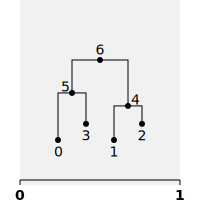

In [7]:
    samples = [
        msprime.SampleSet(1),
        msprime.SampleSet(1, time=1.0)
    ]
    ts = msprime.sim_ancestry(samples)
    print(ts.tables.nodes)
    SVG(ts.draw_svg())

In this example we create two diploid sample individuals, one at the present time
and one taken 5 generations in the past, representing one modern
and one ancient diploid individual. Running this example, we get:

Because nodes `0` and `1` were sampled at time 0, their times in the
node table are both 0; likewise, nodes `2` and `3` are at time 1.0.

### Sample details

Sample individuals and nodes are allocated sequentially in the order that
they are specified. For example:

In [8]:
demography = msprime.Demography.island_model([10, 10], migration_rate=1)
ts = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(1, population=1),
        msprime.SampleSet(2, population=0)],
    demography=demography,
    end_time=0)
print(ts.tables.individuals)
print(ts.tables.nodes)

id	flags	location	metadata
0	0		
1	0		
2	0		
id	flags	population	individual	time	metadata
0	1	1	0	0.00000000000000	
1	1	1	0	0.00000000000000	
2	1	0	1	0.00000000000000	
3	1	0	1	0.00000000000000	
4	1	0	2	0.00000000000000	
5	1	0	2	0.00000000000000	


(Because we're only interested in the sampled nodes and individuals we
stopped the simulation from actually doing anything by setting
`end_time=0`.) Here we define three sample individuals,
and we therefore have three rows in the individual table.
Because these are diploid individuals, the node table contains
six sample nodes. If we look at the `individual` column in the
node table we can see that the first two nodes correspond to individual
`0`, the next two nodes individual `1`, etc. The sample configuration
stated that the first sample should come from population `1` and
the other two from population `0`, and we can see this reflected
in the `population` column of the node table. (Somewhat confusingly,
population values are associated with nodes rather than individuals;
this is mostly for historical reasons.)

The {class}`.SampleSet` class has a number of attributes which default
to `None`. If these are set they will **override** the values
which might be specified elsewhere. For example, we can specify
mixed ploidy samples via the `ploidy` attribute of {class}`.SampleSet`:

In [9]:
ts = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(1, ploidy=3),
        msprime.SampleSet(2)],
    ploidy=1,
    end_time=0)
print(ts.tables.individuals)
print(ts.tables.nodes)

id	flags	location	metadata
0	0		
1	0		
2	0		
id	flags	population	individual	time	metadata
0	1	0	0	0.00000000000000	
1	1	0	0	0.00000000000000	
2	1	0	0	0.00000000000000	
3	1	0	1	0.00000000000000	
4	1	0	2	0.00000000000000	


(Again, we stop the simulation immediately because we're only interested
in the initial samples.) Here we have three sampled individuals again
but in this they are mixed ploidy: the first individual is triploid
and the other two are haploid.

:::{warning}

It is vital to note that setting the `ploidy` value
of {class}`.SampleSet` objects only affects sampling and does
not affect the actual simulation. In this case, the simulation
will be run on the haploid time scale. Some models may not
support mixing of ploidy at all.

:::

If you wish to set up the node and individual IDs in some other way,
the {ref}`sec_ancestry_samples_advanced_sampling` section shows how
to fully control how sample individuals and nodes are defined. However,
this level of control should not be needed for the vast majority of
applications.

(sec_ancestry_samples_advanced_sampling)=

### Advanced sampling

```{eval-rst}
.. todo:: This section should describe how to define samples directly in
    terms of the ``initial_state`` tables and give an example of how to
    use it.

```


---

(sec_ancestry_ploidy)=
## Ploidy

```{eval-rst}
.. todo:: This section is pretty much superseded by the previous discussion
    and we don't actually discuss the important point about timescales
    anywhere. We need to have a top-level section about this somewhere.
```

The samples argument for {func}`.sim_ancestry` is flexible, and allows us
to provide samples in a number of different forms. In single-population
models we can use the numeric form, which gives us {math}`n` samples:

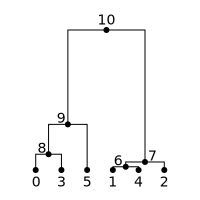

In [10]:
    ts = msprime.sim_ancestry(3)
    SVG(ts.first().draw_svg())


It's important to note that the number of samples refers to the number
of {math}`k`-ploid *individuals*, not the number of sample nodes
in the trees. The `ploidy` argument determines the number of sample
nodes per individual, and is `2` by default; hence, when we asked
for 3 sample individuals in the example above, we got a tree with
six sample *nodes*.

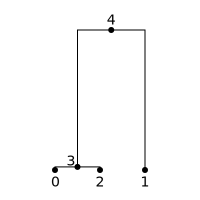

In [11]:
    ts = msprime.sim_ancestry(3, ploidy=1)
    SVG(ts.first().draw_svg())

(sec_ancestry_population_size)=

## Population size

```{eval-rst}
.. todo:: Some nodes on population size and the common gotchas, especially
    how this relates to ploidy. Should link to the demography page and
    model sections for more details.
```

(sec_ancestry_genome_properties)=

## Genome properties

```{eval-rst}
.. todo:: This is text taken from the old api.rst. Reuse/adapt as appropriate.
```

When running simulations we define the length {math}`L` of the sequence in
question using the `length` parameter. This defines the coordinate space
within which trees and mutations are defined. {math}`L` is a continuous value,
so units are arbitrary, and coordinates can take any continuous value from {math}`0` up to
(but not including) {math}`L`. (So, although we recommend setting the units of length to be
analogous to "bases", events can occur at fractional positions.)
Mutations occur in an infinite sites process along this sequence,
and mutation rates are specified per generation, per unit of sequence length.
Thus, given the per-generation mutation rate {math}`\mu`, the rate of mutation
over the entire sequence in coalescent time units is {math}`\theta = 4 N_e \mu
L`. It is important to remember these scaling factors when comparing with
analytical results!

(sec_ancestry_genome_length)=

### Genome length

In [12]:
    msprime.core.set_seed_rng_seed(42)

There are a number of different ways to specify the length of the
chromosome that we want to simulate. In the absence of recombination
and gene conversion, we assume a genome of length 1:

In [13]:
    ts = msprime.sim_ancestry(3)
    ts.sequence_length


1.0

If a recombination or gene conversion rate is specified, though, we
must define a `sequence_length`:

In [14]:
    ts = msprime.sim_ancestry(
        3, recombination_rate=0.1, sequence_length=10, random_seed=2)
    ts.sequence_length, ts.num_trees

(10.0, 4)

In [15]:

    assert ts.num_trees > 1

In this example we have a uniform recombination rate between all
positions along the genome. We can also simulate variable
recombination rates along the genome using a {class}`.RateMap`.

In [16]:
    rate_map = msprime.RateMap(
        position=[0, 10, 12, 20],
        rate=[0.1, 0.5, 0.1])
    ts = msprime.sim_ancestry(3, recombination_rate=rate_map, random_seed=2)
    ts.sequence_length, ts.num_trees

(20.0, 10)

Here we specify varying recombination rates for a genome of length 20,
and there's a hotspot from position 10 to 12. In this case we don't
need to specify the `sequence_length` in the call to `sim_ancestry`
because it's already defined by the {class}`.RateMap`.

(sec_ancestry_discrete_genome)=

### Discrete or continuous?

In [17]:
    msprime.core.set_seed_rng_seed(42)

By default, we assume that the genome we are simulating is *discrete*
so that genome coordinates are at integer positions:

In [18]:
    ts = msprime.sim_ancestry(
        3, recombination_rate=0.1, sequence_length=10, random_seed=2)
    ts.sequence_length

10.0

In [19]:

    assert 1 < ts.num_trees < 5


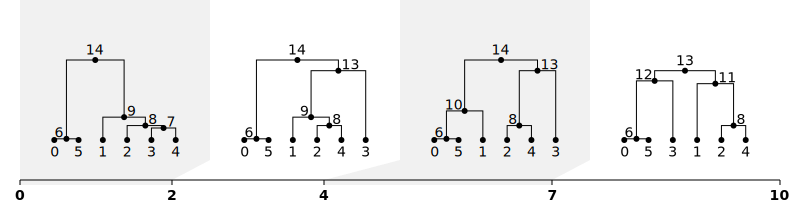

In [20]:
    SVG(ts.draw_svg())

We can also simulate a continous genome by setting
`discrete_genome=False`:

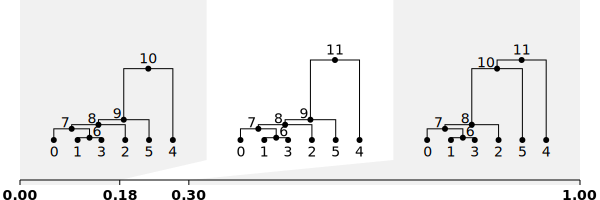

In [21]:
    ts = msprime.sim_ancestry(
        3, recombination_rate=0.25, sequence_length=1, discrete_genome=False,
        random_seed=33)
    SVG(ts.draw_svg())

In [22]:

    assert 1 < ts.num_trees < 5

Here we see that the breakpoints along the genome occur at floating point
positions. Simulating a continuous genome sequence can be useful for
theoretical work, but we recommend using discrete coordinates for most
purposes.

(sec_ancestry_recombination)=

### Recombination

```{eval-rst}
.. todo:: This is old text taken from api.rst. Reuse as appropriate.
    Note that some of this is specific to the Hudson model and so
    should perhaps be moved in there.
```

Similarly, recombination rates are per unit of sequence length and per
generation in `msprime`. Thus, given the per generation crossover rate
{math}`r`, the overall rate of recombination between the ends of the sequence
in coalescent time units is {math}`\rho = 4 N_e r L`. Although breakpoints do
not necessarily occur at integer locations, the underlying recombination model
is finite, and the behaviour of a small number of loci can be modelled using
the {class}`.RecombinationMap` class. However, this is considered an advanced
feature and the majority of cases should be well served with the default
recombination model and number of loci.

In [23]:
    msprime.core.set_seed_rng_seed(42)

```{eval-rst}
.. todo:: Examples of the different ways we can specify recombination
    rates. Ideally we'd start with an
    example with one GC event where we could explain what happened.
    This might be tricky to finesse.

```

In [24]:
    ts = msprime.sim_ancestry(
        3, recombination_rate=0.1, sequence_length=10, random_seed=2)
    ts.sequence_length

10.0

In [25]:

    assert 1 < ts.num_trees < 5

(sec_ancestry_gene_conversion)=

### Gene conversion

In [26]:
    msprime.core.set_seed_rng_seed(42)

Gene conversion events are defined by two parameters: the rate at which gene
conversion events are initiated and the distribution of tract lengths.
In the default case of discrete genome coordinates, tract lengths are drawn
from a geometric distribution with mean gene_conversion_tract_length (which
must be at least 1). Note that if we specify a tract length of 1, then all
gene conversion tracts will have length exactly 1.
In the following example one gene conversion event of length 1 has occured.

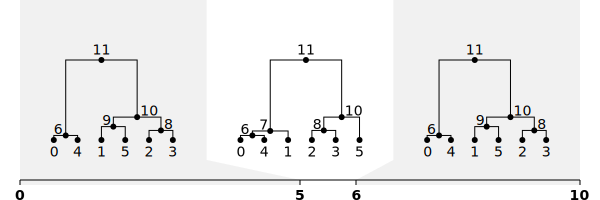

In [27]:
    ts = msprime.sim_ancestry(
        3, gene_conversion_rate=0.02, gene_conversion_tract_length=1,
        sequence_length=10, random_seed=3)
    ts.sequence_length
    SVG(ts.draw_svg())

In [28]:

    assert 1 < ts.num_trees < 5

Continous genomes can also be used. In this case the parameters define
the rate at which gene conversion events are initiated per unit of sequence
length and the mean of the exponentially distributed gene conversion tract
lengths. The following example shows the same simulation as above but for a
continuous genome of length 1 and scaled gene conversion parameters.

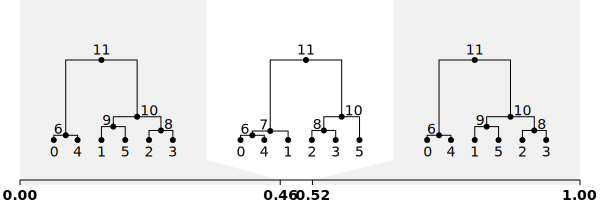

In [29]:
    ts = msprime.sim_ancestry(
        3, gene_conversion_rate=0.2, gene_conversion_tract_length=0.1,
        sequence_length=1, random_seed=3, discrete_genome=False)
    ts.sequence_length
    SVG(ts.draw_svg())

In [30]:

    assert 1 < ts.num_trees < 5

Recombination and gene conversion at constant rates can be simulated alongside.
In the following example recombinations at site 60 and 97 have occured in addition
to a gene conversion event covering the tract from site 76 to site 80.

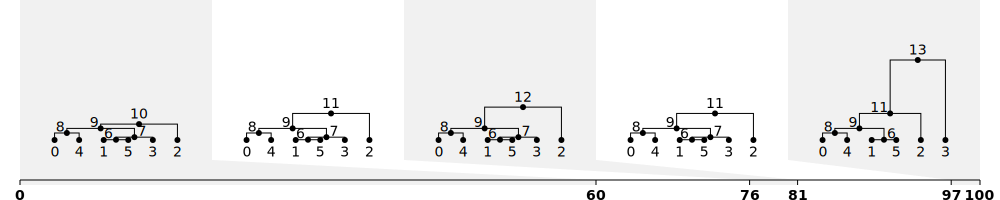

In [31]:
    ts = msprime.sim_ancestry(
        3, sequence_length = 100, recombination_rate=0.003,
        gene_conversion_rate=0.002, gene_conversion_tract_length=5,
        random_seed=6)
    ts.sequence_length
    SVG(ts.draw_svg())

In [32]:

    assert 1 < ts.num_trees < 6

Variable recombination rates and constant gene conversion rates can be combined.
In the next example we define a recombination map with a high recombination rate between
site 10 and site 11 and a constant gene conversion rate with a mean tract length of 3.

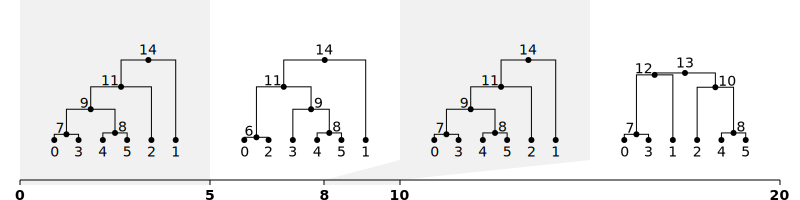

In [33]:
    rate_map = msprime.RateMap(
        position=[0, 10, 11, 20],
        rate=[0.01, 0.5, 0.01])
    ts = msprime.sim_ancestry(
        3, recombination_rate=rate_map,
        gene_conversion_rate=0.01, gene_conversion_tract_length=3,
        random_seed=8)
    ts.sequence_length
    SVG(ts.draw_svg())

In [34]:

    assert 1 < ts.num_trees < 5


(sec_ancestry_multiple_chromosomes)=

### Multiple chromosomes

Multiple chromosomes can be simulated by specifying a recombination map with
single-bp segments with recombination probability 1/2 separating adjacent
chromosomes. By simulating using `sim_ancestry` and `discrete_genome=True`
(the default setting), we set the recombination rate so that chromosomes
separated by such "hotspots" have a 50% chance of being inherited from the
same parent.

The probability that a recombination breakpoint occurs at a given base pair
that has recombination rate {math}`r` is {math}`1-e^{-r}`. Thus, we set the
recombination rate in the base pair segments separating chromosomes to
{math}`\log(2)`. This ensures that the recombination probility each generation
is 1/2.

For example, the following defines a recombination map for three chromosomes
each 1 cM in length:

In [35]:
    import msprime
    import numpy as np

    r_chrom = 1e-8
    r_break = np.log(2)
    positions = [0, 1e6, 1e6 + 1, 2e6, 2e6 + 1, 3e6]
    rates = [r_chrom, r_break, r_chrom, r_break, r_chrom]
    rate_map = msprime.RateMap(positions, rates)

The main purpose of simulating multiple chromosomes together (instead of
running independent simulations for each chromosome) is to capture the correct
correlation between trees on distinct chromosomes. (Note that for many purposes,
this may not be necessary, and simulating chromosomes independently may be
preferred for efficiency.)
To get the correct correlation between chromosomes, we must use the
{ref}`discrete-time Wright-Fisher <sec_ancestry_models_dtwf>` model in the
recent past. Because correlations between chromosomes break down very rapidly,
we only need to simulate using `dtwf` for roughly 10-20 generations, after which
we can switch to the `hudson` model to finish the simulation more efficiently.

For example, simulating 10 sampled diploid individuals using the recombination
map defined above for three chromosomes and switching from the `dtwf` to
`hudson` model 20 generations ago, we run

In [36]:
    tree_sequence = msprime.sim_ancestry(
        10,
        population_size=1000,
        recombination_rate=rate_map,
        model=["dtwf", (20, "hudson")]
    )

To isolate tree sequences for each chromosome, we can trim the full tree sequence
for each chromosome by defining the end points of each chromosome and using
the `keep_intervals` fuction. It is important to specify `simplify=False` so
that node indices remain consistent across chromosomes. The function `trim()`
is then used to trim the tree sequences to the focal chromosome, so that position
indices begin at 0 within each chromosome tree sequence.

In [37]:
    chrom_positions = [0, 1e6, 2e6, 3e6]
    ts_chroms = []
    for j in range(len(chrom_positions) - 1):
        start, end = chrom_positions[j: j + 2]
        chrom_ts = tree_sequence.keep_intervals([[start, end]], simplify=False)
        ts_chroms.append(chrom_ts.trim())

This gives us a list of tree sequences, one for each chromosome, in the order that
they were stitched together in the initial recombination map.

```{eval-rst}
.. todo:: Add a section to the Tutorial showing how to access tree sequences across
    chromosomes and showing the correlation of trees on different chromosomes
    using the ``dtwf`` model.
```

(sec_ancestry_controlling_randomness)=

## Controlling randomness

(sec_ancestry_random_seed)=

### Random seeds

In [38]:
    msprime.core.set_seed_rng_seed(42)

Stochastic simulations depend on a source of randomness, provided
by a [psuedorandom number generator](<https://en.wikipedia.org/wiki/Pseudorandom_number_generator>).
Msprime uses the [GNU Scientific Library](<https://www.gnu.org/software/gsl/doc/html/rng.html>) to generate high-quality
random numbers. The particular trajectory produced by a pseudorandom number
generator is controlled by the "seed" it is provided.

By default, msprime generates random seeds using a private instance of
{class}`random.Random`, which should guarantee unique seeds are produced
even if (e.g.) many simulations are started at the same time in different
processes. In particular, simulations run concurrently in subprocesses using
{mod}`concurrent.futures` or {mod}`multiprocessing` will be assigned unique
seeds by default.

Thus, if we run two simulations with the same parameters, we will get different
results, as we can see from the different times of the last node:

In [39]:
ts = msprime.sim_ancestry(1)
ts.tables.nodes[-1].time

0.13313422084255794


0.13313422084255794

In [40]:
ts = msprime.sim_ancestry(1)
ts.tables.nodes

3.2090602418210956


3.2090602418210956

The `random_seed` argument to {func}`.sim_ancestry` allows us specify
seeds explicitly, making the output of the simulation fully deterministic:

In [41]:
    ts = msprime.sim_ancestry(1, random_seed=42)
    ts.tables.nodes

id,flags,population,individual,time,metadata
0,1,0,0,0.00000000000000,
1,1,0,0,0.00000000000000,
2,0,0,-1,0.93853616544368,


In [42]:
    ts = msprime.sim_ancestry(1, random_seed=42)
    ts.tables.nodes


id,flags,population,individual,time,metadata
0,1,0,0,0.00000000000000,
1,1,0,0,0.00000000000000,
2,0,0,-1,0.93853616544368,


(sec_ancestry_replication)=

### Running replicate simulations

In [43]:
    msprime.core.set_seed_rng_seed(42)

Simulations are random, and we will therefore usually want to have
many independant replicates for a particular set of parameters.
The `num_replicates` parameter provides a convenient and efficient
way to iterate over a number of replicate simulations. For example,
this is a good way to compute the mean and variance of the time to the most
recent common ancestor in a set of simulations:

In [44]:
    import numpy as np

    num_replicates = 100
    tmrca = np.zeros(num_replicates)
    replicates = msprime.sim_ancestry(10, num_replicates=num_replicates, random_seed=42)
    for replicate_index, ts in enumerate(replicates):
        tree = ts.first()
        tmrca[replicate_index] = tree.time(tree.root)
    np.mean(tmrca), np.var(tmrca)


(3.799291711240622, 3.920289255957004)

It's important to note that the replicate simulations are generated
lazily here on demand - the `replicates` variable is a Python iterator.
This means we use much less memory that we would if we stored each
of the replicate simulations in a list.

:::{note}

The return type of `sim_ancestry` changes when we use the
`num_replicates` argument. If `num_replicates` is not specified
or `None`, we return an instance of {class}`tskit.TreeSequence`.
If it is specified, we return an *iterator* over
a set of {class}`tskit.TreeSequence` instances.

:::

## Recording more information

By default `msprime` stores the minimum amount of information required
to represent the simulated genealogical history of the samples. Sometimes
we are interested in more detailed information; this section gives details
of options that allow us to do this.

(sec_ancestry_full_arg)=

### Ancestral recombination graph

In [45]:
    msprime.core.set_seed_rng_seed(42)

In `msprime` we usually want to simulate the coalescent with recombination
and represent the output as efficiently as possible. As a result, we don't
store individual recombination events, but rather their effects on the output
tree sequence. We also do not explicitly store common ancestor events that
do not result in marginal coalescences. For some purposes, however, we want
to get information on the full history of the simulation, not just the minimal
representation of its outcome. The `record_full_arg` option to
{func}`.sim_ancestry` provides this functionality, as illustrated in the
following example:

id	flags	population	individual	time	metadata
0	1	0	0	0.00000000000000	
1	1	0	0	0.00000000000000	
2	1	0	1	0.00000000000000	
3	1	0	1	0.00000000000000	
4	1	0	2	0.00000000000000	
5	1	0	2	0.00000000000000	
6	0	0	-1	0.21230673613116	
7	0	0	-1	0.51485156833449	
8	0	0	-1	0.71161448701612	
9	131072	0	-1	0.91107704517576	
10	131072	0	-1	0.91107704517576	
11	262144	0	-1	1.21743776274571	
12	0	0	-1	1.23130397112052	
13	0	0	-1	4.80416300493305	


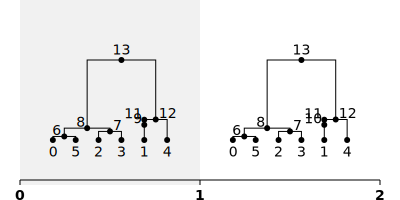

In [46]:
    ts = msprime.sim_ancestry(
        3, recombination_rate=0.1, sequence_length=2,
        record_full_arg=True, random_seed=42)
    print(ts.tables.nodes)
    SVG(ts.draw_svg())


After running the simulation we first print out the [node table](<https://tskit.readthedocs.io/en/stable/data-model.html#node-table>), which
contains information on all the nodes in the tree sequence. Note that `flags`
column contains several different values: all of the sample nodes (at time 0)
have a flag value of `1` ({data}`tskit.NODE_IS_SAMPLE`). Most other
nodes have a flag value of `0`, which is the standard for internal nodes
in a coalescent simulations.

Nodes 9 and 10 have flags equal to 131072 ({data}`.NODE_IS_RE_EVENT`), which
tells us that they correspond to a recombination event in the ARG. A
recombination event results in two extra nodes being recorded, one identifying
the individual providing the genetic material to the left of the breakpoint and
the other identifying the individuals providing the genetic material to the
right. The effect of this extra node can be seen in the trees: node 9 is
present as a 'unary' node in the left hand tree and node 10 in the right.

Node 11 has a flags value of 262144 ({data}`.NODE_IS_CA_EVENT`), which
tells us that it is an ARG common ancestor event that *did not* result
in marginal coalescence. This class of event also results in unary nodes
in the trees, which we can see in the example.

If we wish to reduce these trees down to the minimal representation, we can
use {meth}`tskit.TreeSequence.simplify`. The resulting tree sequence will have
all of these unary nodes removed and will be equivalent to (but not identical, due to
stochastic effects) calling {func}`.sim_ancestry` without the `record_full_arg`
argument.

Migrations nodes are also recording in the ARG using the
{data}`.NODE_IS_MIG_EVENT` flag. See the {ref}`sec_api_node_flags`
section for more details.

(sec_ancestry_record_migrations)=

### Migration events

In [47]:
    msprime.core.set_seed_rng_seed(42)

```{eval-rst}
.. todo:: examples of using the record_migrations

```

(sec_ancestry_census_events)=

### Census events

Census events allow you to add a node to each branch of the tree sequence at a given time
during the simulation. This can be useful when you wish to study haplotypes that are
ancestral to your simulated sample, or when you wish to know which lineages were present in
which populations at specified times.

For instance, the following code specifies a simulation with two samples drawn from each of
two populations. There are two demographic events: a migration rate change and a census
event. At generation 100 and earlier, the two populations exchange migrants at a rate of
0.05. At generation 5000, a census is performed:

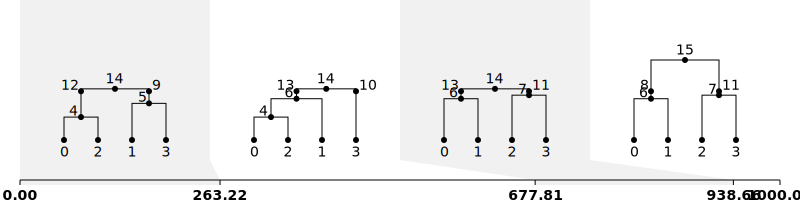

In [48]:
    pop_config = msprime.PopulationConfiguration(sample_size=2, initial_size=1000)
    mig_rate_change = msprime.MigrationRateChange(time=100, rate=0.05)
    ts = msprime.simulate(
                population_configurations=[pop_config, pop_config],
                length=1000,
                demographic_events=[mig_rate_change, msprime.CensusEvent(time=5000)],
                recombination_rate=1e-7,
                random_seed=141)
    SVG(ts.draw_svg())

The resulting tree sequence has nodes on each tree at the specified census time.
These are the nodes with IDs 8, 9, 10, 11, 12 and 13.

This tells us that the genetic material ancestral to the present day sample was
held within 5 haplotypes at time 5000. The node table shows us that four of
these haplotypes (nodes 8, 9, 10 and 11) were in population 0 at this time, and
two of these haplotypes (nodes 12 and 13) were in population 1 at this time.

In [49]:
    print(ts.tables.nodes)

id	flags	population	individual	time	metadata
0	1	0	-1	0.00000000000000	
1	1	0	-1	0.00000000000000	
2	1	1	-1	0.00000000000000	
3	1	1	-1	0.00000000000000	
4	0	1	-1	2350.08685278955454	
5	0	1	-1	3759.20387382751323	
6	0	0	-1	4234.97992185138355	
7	0	1	-1	4598.83898042142937	
8	1048576	0	-1	5000.00000000000000	
9	1048576	0	-1	5000.00000000000000	
10	1048576	0	-1	5000.00000000000000	
11	1048576	0	-1	5000.00000000000000	
12	1048576	1	-1	5000.00000000000000	
13	1048576	1	-1	5000.00000000000000	
14	0	1	-1	5246.90282987397495	
15	0	0	-1	8206.73121309170347	


If we wish to study these ancestral haplotypes further, we can simplify the tree sequence
with respect to the census nodes and perform subsequent analyses on this simplified tree
sequence.
In this example, `ts_anc` is a tree sequence obtained from the original tree sequence
`ts` by labelling the census nodes as samples and removing all nodes and edges that are
not ancestral to these census nodes.

In [50]:
    nodes = [i.id for i in ts.nodes() if i.flags==msprime.NODE_IS_CEN_EVENT]
    ts_anc = ts.simplify(samples=nodes)


## Manipulating simulation time

(sec_ancestry_end_time)=

### Stopping simulations early

In [51]:
    msprime.core.set_seed_rng_seed(42)

```{eval-rst}
.. todo:: Go through an example of using the end time.

```

(sec_ancestry_start_time)=

### Setting the start time

In [52]:
    msprime.core.set_seed_rng_seed(42)

```{eval-rst}
.. todo:: Go through an example of using the start time.

```

(sec_ancestry_initial_state)=

## Specifying the initial state

In [53]:
    msprime.core.set_seed_rng_seed(42)

```{eval-rst}
.. todo:: Go through an example where we specify the initial state
    and explain that specifying the samples is actually the same thing.

```

```{eval-rst}
.. todo:: Port this old documentation to the new format. The sectioning
    is definitely not right here also, as we've just pasted in the old
    tutorial content directly in here.
```

By default `msprime` simulations are initialised by specifying a set of samples,
using the `sample_size` or  `samples` parameters to {func}`.simulate`. This
initialises the simulation with segments of ancestral material covering the
whole sequence. Simulation then proceeds backwards in time until a most recent
common ancestor has been found at all points along this sequence. We can
also start simulations from different initial conditions by using the
`from_ts` argument to {func}`.simulate`. Informally, we take an 'unfinished'
tree sequence as a parameter to simulate, initialise the simulation
from the state of this tree sequence and then run the simulation until
coalescence. The returned tree sequence is then the result of taking the
input tree sequence and completing the trees using the coalescent.

This is useful for forwards-time simulators such as
[SLiM](<https://messerlab.org/slim/>) that can output tree sequences. By running
forward-time simulation for a certain number of generations we obtain a
tree sequence, but these trees may not have had sufficient time to
reach a most recent common ancestor. By using the `from_ts` argument
to {func}`.simulate` we can combine the best of both forwards- and
backwards-time simulators. The recent past can be simulated forwards
in time and the ancient past by the coalescent. The coalescent
simulation is initialised by the root segments of the
input tree sequence, ensuring that the minimal amount of ancestral
material possible is simulated.

<!---
Please see the :ref:`tutorial <sec_tutorial_simulate_from>` for an example of
-->

<!---
how to use this feature with a simple forwards-time Wright-Fisher simulator
-->

### Input requirements

Any tree sequence can be provided as input to this process, but there is a
specific topological requirement that must be met for the simulations to be
statistically correct. To ensure that ancestral segments are correctly
associated within chromosomes when constructing the initial conditions for the
coalescent simulation, forward-time simulators **must** retain the nodes
corresponding to the initial generation. Furthermore, for every sample in the
final generation (i.e. the extant population at the present time) there must be
a path to one of the founder population nodes.

<!---
(Please see the :ref:`tutorial
-->

<!---
<sec_tutorial_simulate_from>` for further explanation of this point and an
-->

<!---
example.)
-->

(sec_ancestry_models)=

## Models

In [54]:
    msprime.core.set_seed_rng_seed(42)

```{eval-rst}
.. todo:: quick overview of what a model *is* and also an example of 
  how to use it.

```

(sec_ancestry_models_hudson)=

### Hudson coalescent

The default simulation model in `msprime` is the coalescent
with recombination, based on the classical `ms` program. 
Please see the {class}`API documentation<.StandardCoalescent>`
for a formal description of the model.

The standard coalescent is the default model of ancestry used
in msprime if we don't specify any value for the `model` parameter.

In [55]:
    ts1 = msprime.sim_ancestry(5, random_seed=2)
    ts2 = msprime.sim_ancestry(5, model="hudson", random_seed=2)
    # This is the same simulation so we should get the same
    # node and edge tables.
    assert ts1.tables.nodes == ts2.tables.nodes
    assert ts1.tables.edges == ts2.tables.edges


(sec_ancestry_models_smc)=

### SMC approximations


```{eval-rst}
.. todo:: Write this section, including a simple example ideally showing 
    a property of an SMC simulation

```

(sec_ancestry_models_dtwf)=

### Discrete Time Wright-Fisher

Msprime provides the option to perform discrete-time Wright-Fisher simulations
for scenarios when the coalescent model is not appropriate, including large
sample sizes, multiple chromosomes, or recent migration.
Please see the {class}`API documentation<.DiscreteTimeWrightFisher>`
for a formal description of the model.

All other parameters can be set as usual. Note that for discrete-time
Wright-Fisher simulations with population structure, each row of the migration
matrix must sum to one or less.

```{eval-rst}
.. todo:: An example of the DTWF. Show the discrete with an example of a
    non-binary tree.
```

(sec_ancestry_models_multiple_mergers)=

### Multiple merger coalescents

Some evolutionary scenarios, such as a skewed offspring distribution
combined with a type III survivorship curve, range expansion, and
rapid adaptation, can predict genealogies with up to four simultaneous
multiple mergers. Msprime provides the option to simulate from two classes
of such genealogical processes: the {class}`.BetaCoalescent` and
the {class}`.DiracCoalescent`. Please see the API documentation for formal
details of the models.

For haploid organisms, both models result in genealogies in which
any number of lineages can merge into a common ancestor,
but only one merger event can take place at a given time. For {math}`p`-ploids,
up to {math}`2p` simultaneous mergers can take place, corresponding to the
{math}`2p` available parental chromosome copies.

In [56]:
msprime.core.set_seed_rng_seed(42)

The diploid Beta-Xi-coalescent can be simulated as follows:

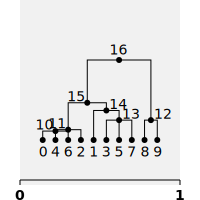

In [57]:
ts = msprime.sim_ancestry(
    samples=5, ploidy=2, random_seed=1,
    model=msprime.BetaCoalescent(alpha=1.001))
SVG(ts.draw_svg())


The specified value of {math}`\alpha = 1.001` corresponds to a heavily skewed
offspring distribution. Values closer to {math}`\alpha = 2` result in trees
whose distribution is closer to that of the standard coalescent, often featuring
no multiple mergers for small sample sizes:

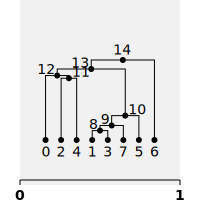

In [58]:
ts = msprime.sim_ancestry(
    samples=4, ploidy=2, random_seed=1,
    model=msprime.BetaCoalescent(alpha=1.8))
SVG(ts.draw_svg())


Multiple mergers still take place in a haploid simulaton, but only one merger
can take place at a given time:

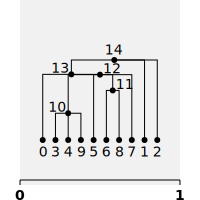

In [59]:
ts = msprime.sim_ancestry(
    samples=10, ploidy=1, random_seed=1,
    model=msprime.BetaCoalescent(alpha=1.001))
SVG(ts.draw_svg())


A haploid simulation results in larger individual mergers than a polyploid simulation
because large mergers typically get broken up into multiple simultaneous mergers
in the polyploid model.

The number of generations between merger events in the Beta-coalescent depends
nonlinearly on both {math}`\alpha` and the population size {math}`N`
as detailed above.
For a fixed {math}`\alpha`, the number of generations between common ancestor events
is proportional to {math}`N^{\alpha - 1}`, albeit with a complicated constant of
proportionality that depends on {math}`\alpha`. The dependence on {math}`\alpha`
for fixed {math}`N` is not monotone. Thus, branch lengths and the number of
generations until a most recent common ancestor depend on both of these parameters.

To illustrate, for {math}`\alpha` close to 2 the relationship between effective
population size and number of generations is almost linear:

In [60]:
ts = msprime.sim_ancestry(
    samples=1, ploidy=2, random_seed=1, population_size=10,
    model=msprime.BetaCoalescent(alpha=1.99))
tree = ts.first()
print(tree.tmrca(0,1))
ts = msprime.sim_ancestry(
    samples=1, ploidy=2, random_seed=1, population_size=1000,
    model=msprime.BetaCoalescent(alpha=1.99))
tree = ts.first()
print(tree.tmrca(0,1))


0.14959691919068155
14.286394871874865


For {math}`\alpha` close to 1 the effective population size has little effect:

In [61]:
ts = msprime.sim_ancestry(
    samples=1, ploidy=2, random_seed=1, population_size=10,
    model=msprime.BetaCoalescent(alpha=1.1))
tree = ts.first()
print(tree.tmrca(0,1))
ts = msprime.sim_ancestry(
    samples=1, ploidy=2, random_seed=1, population_size=1000,
    model=msprime.BetaCoalescent(alpha=1.1))
tree = ts.first()
print(tree.tmrca(0,1))


16.311807036386615
25.85247192870844


The Dirac-coalescent is simulated similarly in both the diploid case:

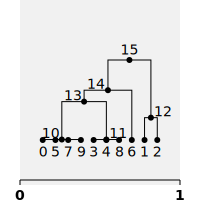

In [62]:
ts = msprime.sim_ancestry(
    samples=5, ploidy=2, random_seed=1,
    model=msprime.DiracCoalescent(psi=0.9, c=10))
SVG(ts.draw_svg())


and in the haploid case:

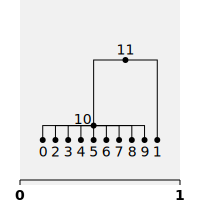

In [63]:
ts = msprime.sim_ancestry(
    samples=10, ploidy=1, random_seed=1,
    model=msprime.DiracCoalescent(psi=0.9, c=10))
SVG(ts.draw_svg())


As with the Beta-coalescent, a haploid simulation results in larger individual
mergers than a polyploid simulation because large mergers typically get broken
up into multiple simultaneous mergers in the polyploid model. Larger values
of the parameter {math}`c > 0` result in more frequent multiple mergers,
while larger values of {math}`0 < \psi \leq 1` result in multiple mergers
with more participating lineages. Setting either parameter to 0 would correspond
to the standard coalescent.

The Dirac-coalescent is obtained as the infinite population scaling limit of
Moran models, and therefore branch lengths are proportional to {math}`N^2`
generations, as opposed to {math}`N` generations under the standard coalescent.

In [64]:
ts = msprime.sim_ancestry(
    samples=1, ploidy=2, random_seed=1, population_size=10,
    model=msprime.DiracCoalescent(psi=0.1, c=1))
tree = ts.first()
print(tree.tmrca(0,1))
ts = msprime.sim_ancestry(
    samples=1, ploidy=2, random_seed=1, population_size=100,
    model=msprime.DiracCoalescent(psi=0.1, c=1))
tree = ts.first()
print(tree.tmrca(0,1))


64.7216732891741
6472.167328917411


(sec_ancestry_models_selective_sweeps)=

### Selective sweeps

```{eval-rst}
.. todo:: Document the selective sweep models.
```

```{eval-rst}
.. todo:: examples of the selective sweeps models. We want to have
    a single sweep reverting to Hudson, and also lots of sweeps.
```

(sec_ancestry_models_multiple_models)=

### Multiple models

```{eval-rst}
.. todo:: This is copied from the old tutorial and is out of date now.
    Update the to use the new model=[(time, model)]`` syntax.
    It's also too focused on the DTWF model.
```

In some situations Wright-Fisher simulations are desireable but less
computationally efficient than coalescent simulations, for example simulating a
small sample in a recently admixed population. In these cases, a hybrid model
offers an excellent tradeoff between simulation accuracy and performance.

This is done through a {class}`.SimulationModelChange` event, which is a special type of
demographic event.

For example, here we switch from the discrete-time Wright-Fisher model to the
standard Hudson coalescent 500 generations in the past:

In [65]:
ts = msprime.simulate(
    sample_size=6, Ne=1000, model="dtwf", random_seed=2,
    demographic_events=[
        msprime.SimulationModelChange(time=500, model="hudson")])
print(ts.tables.nodes)
# id      flags   population      individual      time    metadata
# 0       1       0       -1      0.00000000000000
# 1       1       0       -1      0.00000000000000
# 2       1       0       -1      0.00000000000000
# 3       1       0       -1      0.00000000000000
# 4       1       0       -1      0.00000000000000
# 5       1       0       -1      0.00000000000000
# 6       0       0       -1      78.00000000000000
# 7       0       0       -1      227.00000000000000
# 8       0       0       -1      261.00000000000000
# 9       0       0       -1      272.00000000000000
#10      0       0       -1      1629.06982528980075


id	flags	population	individual	time	metadata
0	1	0	-1	0.00000000000000	
1	1	0	-1	0.00000000000000	
2	1	0	-1	0.00000000000000	
3	1	0	-1	0.00000000000000	
4	1	0	-1	0.00000000000000	
5	1	0	-1	0.00000000000000	
6	0	0	-1	78.00000000000000	
7	0	0	-1	227.00000000000000	
8	0	0	-1	261.00000000000000	
9	0	0	-1	272.00000000000000	
10	0	0	-1	1629.06982528980075	


Because of the integer node times, we can see here that most of the coalescent
happened during the Wright-Fisher phase of the simulation, and as-of 500
generations in the past, there were only two lineages left. The continuous
time standard coalescent model was then used to simulate the ancient past of
these two lineages.

## Notes for ms users

```{eval-rst}
.. todo:: This is copied from the old api.rst page and needs some updating.
```

The simulation model in `msprime` closely follows the classical `ms`
program. Unlike `ms`, however, time is measured in generations rather than
in units of {math}`4 N_e` generations, i.e., "coalescent units".
This means that when simulating a population with diploid effective size {math}`N_e`,
the mean time to coalescence between two samples
in an `msprime` simulation will be around {math}`2 N_e`,
while in an `ms` simulation, the mean time will be around {math}`0.5`.
Internally, `msprime` uses the same algorithm as `ms`,
and so the `Ne` parameter to the {func}`.simulate` function
still acts as a time scaling, and can be set to `0.5` to match many theoretical results,
or to `0.25` to match `ms`. Population sizes for each
subpopulation and for past demographic events are also defined as absolute values, **not**
scaled by `Ne`. All migration rates and growth rates are also per generation.

:::{warning}

This parameterisation of recombination, mutation and
migration rates is different to {program}`ms`, which states these
rates over the entire region and in coalescent time units. The
motivation for this is to allow the user change the size of the simulated
region without having to rescale the recombination, gene conversion, and mutation rates,
and to also allow users directly state times and rates in units of
generations. However, the `mspms` command line application is
fully {program}`ms` compatible.
If recombination and gene conversion are combined the gene conversion
rate in {program}`ms` is determined by the ratio {math}`f`, which corresponds to
setting {math}`g = f r`. In `msprime` the gene conversion rate {math}`g` is
set independently and does not depend on the recombination rate. However,
`mspms` mimics the {program}`ms` behaviour.

:::